In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# from desc import set_device
# set_device("gpu")

In [2]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [4]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.14.2+661.g47d74726f.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: CPU, with 18.71 GB available memory.


In [5]:
from diffrax import Euler, Heun
from desc.particles import *

In [6]:
eq = desc.examples.get("precise_QA")
model = VacuumGuidingCenterTrajectory(frame="flux")
ts = np.linspace(0, 1e-4, 1000)
rhos = jnp.linspace(0.7, 0.8, 1)
initializer = ManualParticleInitializerFlux(
    rho0=rhos,
    theta0=0,
    zeta0=0,
    xi0=1,
    E=1e-1,
    m=4.0,
    q=1.0,
)
fig = plot_3d(eq, "|B|", alpha=0.5)
plot_particle_trajectories(eq, model, initializer, ts, fig=fig)

/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)
/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)


In [ ]:
import desc
from desc.plotting import plot_particle_trajectories
from desc.particles import (
    ManualParticleInitializerFlux,
    VacuumGuidingCenterTrajectory,
)

eq = desc.examples.get("precise_QA")
model = VacuumGuidingCenterTrajectory(frame="flux")
ts = np.linspace(0, 1e-2, 1000)


def fun_eq(n):
    rhos = jnp.linspace(0.7, 0.8, n)  # Use a constant value for all particles

    initializer = ManualParticleInitializerFlux(
        rho0=rhos,
        theta0=0,
        zeta0=0,
        xi0=0.7,
        E=1e-1,
        m=4.0,
        q=1.0,
    )

    x0, args = initializer.init_particles(model=model, field=eq)
    ms, qs, mus = args[:3]
    rpz, _ = trace_particles(
        field=eq,
        y0=x0,
        ms=ms,
        qs=qs,
        mus=mus,
        model=model,
        ts=ts,
    )
    return rpz

In [ ]:
Ts = [5.13, 5.74, 5.77, 5.45, 5.54, 6.04, 8.05, 9.85]
Ns = [1, 10, 50, 100, 500, 1000, 5000, 10000]
plt.semilogx(Ns, Ts)
plt.xlabel("Number of particles")
plt.ylabel("Time (s)")
plt.title("Scaling of particle tracing time with number of particles")

In [ ]:
import warnings

Ns = [1, 10, 50, 100, 500, 1000, 5000, 10000]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for n in Ns:
        print(f"Number of particles: {n}")
        %timeit fun_eq(n).block_until_ready()

In [ ]:
import desc
from desc.plotting import plot_particle_trajectories
from desc.particles import (
    ManualParticleInitializerLab,
    VacuumGuidingCenterTrajectory,
)

eq = desc.examples.get("precise_QA")
field = desc.io.load("../tests/inputs/precise_QA_helical_coils.h5")
ts=np.linspace(0, 1e-2, 1000)
model = VacuumGuidingCenterTrajectory(frame="lab")
grid_trace = LinearGrid(rho=0.7, theta=0)
r0 = eq.compute("R", grid=grid_trace)["R"]

def fun_field(n):
    rhos = [r0] * n

    initializer = ManualParticleInitializerLab(
        R0=rhos,
        phi0=0,
        Z0=0,
        xi0=0.7,
        E = 1e-1,
        m = 4.0,
        q = 1.0,
        eq = eq, # needed for flux -> lab coordinate transformation
    )

    x0, args = initializer.init_particles(model=model, field=field)
    ms, qs, mus = args[:3]
    rpz, _ = trace_particles(
        field=field, y0=x0, ms=ms, qs=qs, mus=mus, model=model, ts=ts,
    )
    return rpz

%timeit fun_field(10).block_until_ready()

In [ ]:
import warnings

Ns = [1, 50, 100, 500, 1000, 5000, 10000]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for n in Ns:
        print(f"Number of particles: {n}")
        %timeit fun_field(n).block_until_ready()

In [ ]:
Ns = [1, 50, 100, 500, 1000, 5000, 10000]
Ts = [15.1, 14.9, 16.5, 26.8, 39.7, 141., 268.]
plt.semilogx(Ns, Ts)
plt.xlabel("Number of particles")
plt.ylabel("Time (s)")
plt.title("Scaling of particle tracing time with number of particles")

In [ ]:
def custom_B(coords, params):
    """Custom magnetic field function."""
    xyz = rpz2xyz(coords)
    X, Y, Z = xyz.T
    B0, dB = params
    B = jnp.zeros_like(coords)
    B = B.at[:, 2].set(B0 + dB * Z)
    B = xyz2rpz_vec(B, phi=coords[:, 1])
    return B

B0 = 1.0  # Constant magnetic field strength
dB = 0.1  # Gradient of the magnetic field
E = 1e8  # Particle energy
xi0 = 0.9  # Initial pitch angle
field = MagneticFieldFromUser(fun=custom_B, params=(B0, dB))
R0 = np.array([1.0])
particles = ManualParticleInitializerLab(R0=R0, phi0=0, Z0=0, xi0=xi0, E=E)
model = VacuumGuidingCenterTrajectory(frame="lab")
ts = np.linspace(0, 1e-6, 10)
x0, args = particles.init_particles(model=model, field=field)
ms, qs, mus = args[:3]
rpz, vpar = trace_particles(
    field=field, y0=x0, ms=ms, qs=qs, mus=mus, model=model, ts=ts,
)
z = x0[0, -1] * ts - dB * mus[0] / ms[0] * ts**2 / 2
vpar_exact = x0[0, 3] - dB * mus[0] / ms[0] * ts

assert np.allclose(rpz[0, :, 2], z, atol=1e-5)
assert np.allclose(vpar[0, :, 0], vpar_exact, atol=1e-5)

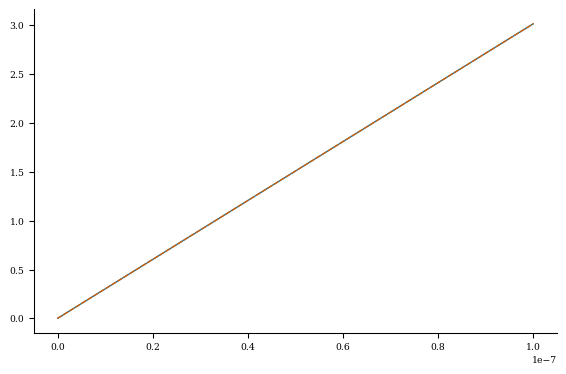

In [7]:
B0 = 1.0  # Constant magnetic field strength
dB = 0.1  # Gradient of the magnetic field
E = 1e8  # Particle energy
xi0 = 0.9  # Initial pitch angle
R0t = 3.0
field = ToroidalMagneticField(B0=B0, R0=R0t)
R0 = np.array([4.0])
particles = ManualParticleInitializerLab(R0=R0, phi0=0, Z0=0.0, xi0=xi0, E=E)
model = VacuumGuidingCenterTrajectory(frame="lab")
ts = np.linspace(0, 1e-7, 10)
fig, data = plot_particle_trajectories(field, model, particles, ts, return_data=True)
vd = (
    particles.m[0]
    / particles.q[0]
    / B0 / R0t
    * (particles.vpar0[0] ** 2 + (particles.v0[0] ** 2 - particles.vpar0[0] ** 2) / 2)
)
vexact = vd * ts
plt.plot(ts, data["Z"][0])
plt.plot(ts, vexact, "--")

In [ ]:
vd = (
    particles.m[0]
    / particles.q[0]
    / B0
    * (
        particles.vpar0[0] ** 2
        + (particles.v0[0]**2 - particles.vpar0[0] ** 2) / 2
    )
)
vd*ts

In [10]:
from desc.particles import *
field = ToroidalMagneticField(B0=1.0, R0=3.0)
R0 = np.array([4.1])
particles = ManualParticleInitializerLab(R0=R0, phi0=0, Z0=0, xi0=0.5, E=1e2)
model = VacuumGuidingCenterTrajectory(frame="lab")
ts = np.linspace(0, 1e-10, 10)
plot_particle_trajectories(field=field, model=model, initializer=particles, ts=ts, return_data=True)

(Figure({
     'data': [{'hovertext': 'Particle[0]',
               'line': {'color': 'black', 'dash': 'solid', 'width': 5},
               'marker': {'size': 0},
               'mode': 'lines',
               'name': 'Particle[0]',
               'showlegend': False,
               'type': 'scatter3d',
               'x': {'bdata': ('ZmZmZmZmEEARZWZmZmYQQBFhZmZmZh' ... 'ZmZmYQQBcRZmZmZhBAbvplZmZmEEA='),
                     'dtype': 'f8'},
               'y': {'bdata': ('AAAAAAAAAADg76jXzXK6PrvtqNfNcs' ... 'McdCTnPqrCqNfNcuo+Ss2dkifB7T4='),
                     'dtype': 'f8'},
               'z': {'bdata': ('AAAAAAAAAAABnCEUktHvPQKcIRSS0f' ... '3RX9cbPu6bIRSS0R8+tudSK+LlIT4='),
                     'dtype': 'f8'}},
              {'hovertext': 'Particle[0] End Point',
               'marker': {'color': 'black', 'size': 10},
               'mode': 'markers',
               'name': 'Particle[0] End Point',
               'showlegend': False,
               'type': 'scatter3d',
          

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 583 ms
Timer: Objective build = 816 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 572 ms
Timer: LinearConstraintProjection build = 2.71 sec
Number of parameters: 12
Number of objectives: 50
Timer: Initializing the optimization = 4.13 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          5.659e-02                                    3.166e-01   
       1              2          2.787e-03      5.380e-02      2.459e-01    

(<Figure size 480.236x480.236 with 2 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{B}|$($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>], dtype=object))

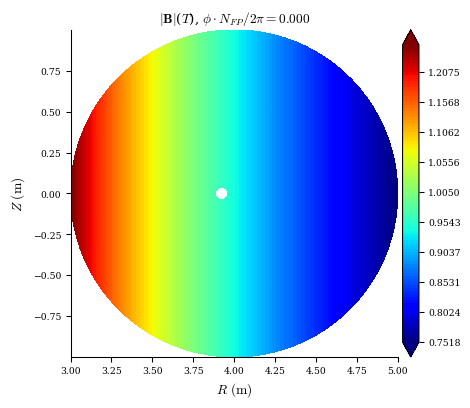

In [6]:
rmajor = 4.0
rminor = 1.0
surf = FourierRZToroidalSurface(
    R_lmn=np.array([rmajor, rminor]),
    modes_R=np.array([[0, 0], [1, 0]]),
    Z_lmn=np.array([0, -1]),
    modes_Z=np.array([[0, 0], [-1, 0]]),
)
eq = Equilibrium(surface=surf, M=4, N=0, Psi=3)
eq.solve(verbose=3)
plot_section(eq, "|B|")

In [7]:
from diffrax import Euler, Heun, Tsit5
from desc.particles import *
R0 = np.array([4.2, 4.3])
particles = ManualParticleInitializerLab(R0=R0, phi0=0, Z0=-0.5, xi0=1, E=1e7, eq=eq)
model = VacuumGuidingCenterTrajectory(frame="flux")
ts = np.linspace(0, 5e-7, 1000)

eq.iota = eq.get_profile("iota")
fig = plot_3d(eq, "|B|", alpha=0.5)
fig, data = plot_particle_trajectories(
    field=eq, model=model, initializer=particles, ts=ts, 
    return_data=True, solver=Tsit5(), 
    fig=fig, bounds_R=(0, 1),
)
fig

/CODES/DESC/desc/utils.py:572: UserWarning: Setting rotational transform profile on an equilibrium with fixed toroidal current, removing existing toroidal current profile.
  warnings.warn(msg, err)
/CODES/DESC/desc/particles.py:666: UserWarning:

The input coordinates are in lab coordinates, but the model operates in flux coordinates. Converting the given coordinates to flux frame.



In [ ]:
def f1(x, eq, m, q, mu):
    rho, theta, zeta, vpar = x
    grid = Grid(
        jnp.array([rho, theta, zeta]).T,
        spacing=jnp.zeros((3,)).T,
        jitable=True,
        sort=False,
    )
    data_keys = [
        "B",
        "|B|",
        "grad(|B|)",
        "e^rho",
        "e^theta",
        "e^zeta",
        "b",
    ]

    transforms = get_transforms(data_keys, eq, grid, jitable=True)
    profiles = get_profiles(data_keys, eq, grid)
    data = compute_fun(eq, data_keys, eq.params_dict, transforms, profiles)

    # derivative of the guiding center position in R, phi, Z coordinates
    Rdot = vpar * data["b"] + (
        (m / q / data["|B|"] ** 2)
        * ((mu * data["|B|"]) + vpar**2)
        * cross(data["b"], data["grad(|B|)"])
    )
    rhodot = dot(Rdot, data["e^rho"])
    thetadot = dot(Rdot, data["e^theta"])
    zetadot = dot(Rdot, data["e^zeta"])
    vpardot = -mu * dot(data["b"], data["grad(|B|)"])
    dxdt = jnp.array([rhodot, thetadot, zetadot, vpardot]).reshape(x.shape)
    return dxdt.squeeze()

def f2(x, field, m, q, mu, **kwargs):
    vpar = x[-1]
    coord = x[:-1]

    field_compute = lambda y: jnp.linalg.norm(
        field.compute_magnetic_field(y, **kwargs), axis=-1
    ).squeeze()

    # magnetic field vector in R, phi, Z coordinates
    B = field.compute_magnetic_field(coord, **kwargs)
    grad_B = Derivative(field_compute, mode="grad")(coord)

    modB = jnp.linalg.norm(B, axis=-1)
    b = B / modB
    # factor of R from grad in cylindrical coordinates
    grad_Bphi = safediv(grad_B[1], coord[0])
    grad_B = grad_B.at[1].set(grad_Bphi)
    Rdot = vpar * b + (m / q / modB**2 * (mu * modB + vpar**2)) * cross(b, grad_B)

    vpardot = jnp.atleast_2d(-mu * dot(b, grad_B))
    dxdt = jnp.hstack([Rdot, vpardot.T]).reshape(x.shape)
    return dxdt.squeeze()

In [ ]:
eq = get("precise_QA")
field = desc.io.load("../tests/inputs/precise_QA_helical_coils.h5")

In [ ]:
r = jnp.linspace(0.1, 0.99, 2000)

particles = ManualParticleInitializerFlux(
    rho0 = r,
    theta0 = 0.0,
    zeta0 = 0.0,
    xi0 = 1.0,
    E = 1e3,
    eq=eq,
)
model = VacuumGuidingCenterTrajectory(frame="flux")
model_lab = VacuumGuidingCenterTrajectory(frame="lab")

In [ ]:
x0, args = particles.init_particles(model, eq)

In [ ]:
x0_lab, args_lab = particles.init_particles(model_lab, field)

In [ ]:
m, q, mu = args
m = m[0]
q = q[0]    
mu = mu[0]

In [ ]:
intf1 = lambda x: f1(x, eq, m, q, mu)
intf2 = lambda x: f2(x, field, m, q, mu)

In [ ]:
s1 = jax.vmap(intf1)(x0)

In [ ]:
s2 = jax.vmap(intf2)(x0_lab)